# ANATOMICAL MODEL GENERATION

In [1]:
''' Generates and saves the anatomical model (MFs, GrCs and GoCs positions and connectivities) using 
    constraints and code from Solinas et al. (2010) (DOI: 10.3389/fncel.2010.00012) and from 
    Casali et al. (2019) (DOI: 10.3389/fninf.2019.00037) '''

' Generates and saves the anatomical model (MFs, GrCs and GoCs positions and connectivities) using \n    constraints and code from Solinas et al. (2010) (DOI: 10.3389/fncel.2010.00012) and from \n    Casali et al. (2019) (DOI: 10.3389/fninf.2019.00037) '

## CELL POSITIONS GENERATION

In [2]:
## importing libraries ##
import random, numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import os
import sys
from operator import itemgetter
from collections import Counter
from itertools import chain 


In [3]:
################# PARAMETERS ###########################
######## 01_anatomical_model_generation ################

seed = 0 ## seed for the generation of cells positions
total_size = 100.0 ## side size in um of the anatomical model cube  

# densities of cells populations 
glos_density = 3e-4 ## Mossy fibers densities
grcs_density = 3.9e-3 ## Granule cells densities
gocs_density = 9e-6 ## Golgi cells densities

########################################################

In [4]:
# Creating folder to store the model visualizations
VISUALIZATIONS_DIR = "../results/anatomical_model_visualizations"
os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)

In [5]:
# initializing seed for the cell positions generations
np.random.seed(seed)
random.seed(seed)

In [6]:
# function to separate coordinates
def separate_coords(samples):
    xsamples = []
    ysamples = []
    zsamples = []
    
    for coord in samples:
        x = coord[0]
        y = coord[1]
        z = coord[2]
        xsamples.append(x)
        ysamples.append(y)
        zsamples.append(z)

    xsamples = np.asarray(xsamples)
    ysamples = np.asarray(ysamples)
    zsamples = np.asarray(zsamples)
    
    return xsamples, ysamples, zsamples

In [7]:
# the following functions are scaffold functions used for generating the anatomical model 
# (from reference with DOI: 10.3389/fninf.2019.00037)

def exclude_index(arr, index):
    return [arr[i] for i in range(len(arr)) if i != index]
    return arr[np.arange(len(arr),dtype=int) != index]

def add_y_axis(points, min, max):
    return np.insert(points, 1, np.random.uniform(min, max, points.shape[0]), axis=1)

def define_bounds(possible_points, cell_bounds):
    '''
        Compare a 2xN matrix of XZ coordinates to a matrix 2x3 with a minimum column and maximum column of XYZ coordinates.
    '''
    x_mask = (possible_points[:,0].__ge__(cell_bounds[0,0])) & (possible_points[:,0].__le__(cell_bounds[0,1]))
    z_mask = (possible_points[:,1].__ge__(cell_bounds[2,0])) & (possible_points[:,1].__le__(cell_bounds[2,1]))
    return x_mask, z_mask

def compute_circle(center, radius, n_samples=50):
    '''
        Create `n_samples` points on a circle based on given `center` and `radius`.

        :param center: XYZ vector of the circle center
        :type center: array-like
        :param radius: Radius of the circle
        :type radius: scalar value
        :param n_samples: Amount of points on the circle.
        :type n_samples: int
    '''
    nodes = np.linspace(0,2*np.pi,n_samples, endpoint=False)
    x, y = np.sin(nodes)*radius+center[0], np.cos(nodes)*radius+center[1]
    return np.column_stack([x,y])

def get_candidate_points(center, radius, bounds, min_ϵ, max_ϵ, return_ϵ=False):
    # Get n points 2 + rnd_ϵ radii away from the center, see `Wiki > Placement > Layered > Epsilon`
    # TODO: Add wiki doc
    rnd_ϵ = np.random.uniform(min_ϵ, max_ϵ)
    possible_points = compute_circle(center, radius * 2 + rnd_ϵ)
    x_mask, z_mask = define_bounds(possible_points, bounds)
    if return_ϵ:
        return possible_points[x_mask & z_mask], rnd_ϵ
    else:
        return possible_points[x_mask & z_mask]

In [8]:
## total size (and thickness) of the cube
layer_thickness = total_size
size = total_size

In [9]:
## cell populations with corresponding cell_radius and densities

class glos:
    available_volume = size**3
    density = glos_density
    distance_multiplier_min = 0.75
    distance_multiplier_max = 1.25
    n_cells_to_place = int(available_volume * density)
    #n_cells_to_place = 315
    placement_volume = available_volume/n_cells_to_place
    placement_radius = (0.75*placement_volume/np.pi)**(1./3.)
    n_sublayers = np.round(size/(1.5*placement_radius))
    cell_radius = 1.5
    
class grcs:   
    available_volume = size**3
    density = grcs_density
    distance_multiplier_min = 0.5
    distance_multiplier_max = 0.5
    n_cells_to_place = int(available_volume * density)
    #n_cells_to_place = 6000
    placement_volume = available_volume/n_cells_to_place
    placement_radius = (0.75*placement_volume/np.pi)**(1./3.)
    n_sublayers = np.round(size/(1.5*placement_radius))
    cell_radius = 2.5
    
class gocs:   
    available_volume = size**3
    density = gocs_density
    distance_multiplier_min = 0.75
    distance_multiplier_max = 1.25
    n_cells_to_place = round(available_volume * density)
    #n_cells_to_place = 11
    placement_volume = available_volume/n_cells_to_place
    placement_radius = (0.75*placement_volume/np.pi)**(1./3.)
    n_sublayers = np.round(size/(1.5*placement_radius))
    cell_radius = 8.0

In [10]:
## function used to divide the granular layer for each population
def partition_layer(n_sublayers):
    
    # Allow restricted placement along the Y-axis.
    yMin = 0.0
    layer_thickness = size
    sublayerHeight = layer_thickness / n_sublayers
    # Divide the Y axis into equal pieces
    sublayerYs = np.linspace(0.0, layer_thickness, num = int(n_sublayers+1))
    # Add the bottom of the lowest layer and translate all the points by the layer's Y position, keeping the Y restriction into account
    ## sublayerYs = np.insert(sublayerYs, 0, 0) + self.layer_instance.origin[1] + yMin * self.layer_instance.thickness
    # Create pairs of points on the Y axis corresponding to the bottom and ceiling of each sublayer partition
    sublayerPartitions = np.column_stack([sublayerYs, np.roll(sublayerYs, -1)])[:-1]
    return sublayerPartitions


In [11]:
## function to place each cell population
def place(cell_type):
    
    np.random.seed(seed)
    random.seed(seed) 
    # radio de la neurona
    cell_radius = cell_type.cell_radius
    
    # origen -> (0,0,0)
    restricted_origin = np.array([
        0.0,
        layer_thickness * 0.0,
        0.0
    ])
    
    #dimensiones (100um, 100um, 100um)
    restricted_dimensions = np.array([
        size,
        layer_thickness,
        size
    ])
    
    # límites de la neurona [(radio, radio, radio), (size-radio, size-radio, size-radio)]
    cell_bounds = np.column_stack((
    restricted_origin + cell_radius,
    restricted_origin + restricted_dimensions - cell_radius
    ))
    
    
    ϵ = cell_type.placement_radius - cell_radius
    ## Sublayer partitioning
    partitions = partition_layer(cell_type.n_sublayers)
    ## Adjust partitions to cell radius
    partitions = partitions + np.array([cell_radius, -cell_radius])

    ## Placement
    min_ϵ = cell_type.distance_multiplier_min * ϵ
    max_ϵ = cell_type.distance_multiplier_max * ϵ
    cells_per_sublayer = np.round(cell_type.n_cells_to_place / cell_type.n_sublayers)
    layer_cell_positions = np.empty((0, 3))
    print(cells_per_sublayer)
    types = {
        "0": glos,
        "1": grcs,
        "2": gocs,
    }

    ## en global_cell_positions están guardadas el tipo de neurona ya posicionada y sus tres coordenadas
    previously_placed_cells = global_cell_positions[:,[1,2,3]]
    previously_placed_types = np.array(global_cell_positions[:,0], dtype = int)
    other_celltype_radii = list(previously_placed_types)
    other_celltype_radii = [types[str(other_celltype_radii[i])].cell_radius for i in range(len(other_celltype_radii))]
    

    if len(global_cell_positions) > 0:
        previously_placed_min_dist = np.array(other_celltype_radii) + cell_radius
    else:
        previously_placed_min_dist = np.empty((0))
        
    #conteo de las neuronas ya posicionadas
    other_celltype_count = previously_placed_min_dist.shape[0]
    
    #para cada subcapa
    for sublayer_id in np.arange(cell_type.n_sublayers):
        print("SUBLAYER:" + str(sublayer_id))
        
        sublayer_id = int(sublayer_id)
        sublayer_floor = partitions[sublayer_id, 0]
        sublayer_roof = partitions[sublayer_id, 1]
        sublayer_attempts = 0

        # Generate the first cell's position.
        starting_position = np.array((
            np.random.uniform(cell_bounds[0, 0], cell_bounds[0, 1]), # X
            #np.random.uniform(sublayer_floor + cell_radius, sublayer_roof - cell_radius), # Y
            np.random.uniform(cell_bounds[1, 0], cell_bounds[1, 1]),
            np.random.uniform(cell_bounds[2, 0], cell_bounds[2, 1])  # Z
        ))

        #print(starting_position)
        planar_start = [starting_position[0], starting_position[2]] # X & Z
        # Get all possible new cell positions
        planar_candidates = get_candidate_points(planar_start, cell_radius, cell_bounds, min_ϵ, max_ϵ)
        #print(planar_candidates)
        
        # If there are no possible points, force the cell position to be in the middle of surface
        if planar_candidates.shape[0] == 0:
            starting_position = np.array([
                cell_bounds[0, 0] + (cell_bounds[0, 1] - cell_bounds[0, 0]) / 2., # X
                np.random.uniform(sublayer_floor, sublayer_roof),   # Y
                cell_bounds[2, 0] + (cell_bounds[2, 1] - cell_bounds[2, 0]) / 2.  # Z
            ])
            planar_candidates = get_candidate_points(planar_start, cell_radius, cell_bounds, min_ϵ, max_ϵ)
            
#             if planar_candidates.shape[0] == 0:
#                 print("[WARNING] Could not place a single cell in {} starting from the middle of the simulation volume: Maybe the volume is too low or cell radius/epsilon too big. Sublayer skipped!".format(                    
#                     sublayer_id
#                 ))
#             continue


        # posiciones finales    
        placed_positions = np.array([starting_position])
        planar_placed_positions = np.array([starting_position[[0,2]]])
        full_coords = add_y_axis(planar_placed_positions, sublayer_floor, sublayer_roof)
        # guardamos esta primera posicion
        good_points_store = [np.copy(full_coords)]
        # la guardamos como la última posición establecida
        last_position = starting_position

        # para el resto de neuronas por colocar: 
        for current_cell_count in np.arange(1, cells_per_sublayer, dtype=int):
            
            #print(current_cell_count)
            # Subtract failed placement attempts from loop counter
            current_cell_count = current_cell_count - sublayer_attempts
            planar_candidates, rnd_ϵ = get_candidate_points(last_position[[0, 2]], cell_radius, cell_bounds, min_ϵ, max_ϵ, return_ϵ=True)
            full_coords = add_y_axis(planar_candidates, sublayer_floor, sublayer_roof)
            inter_cell_soma_dist = cell_radius * 2 + rnd_ϵ
            sublayer_distances = distance.cdist(planar_candidates, planar_placed_positions)
            good_indices = list(np.where(np.sum(sublayer_distances > inter_cell_soma_dist, axis=1) == current_cell_count)[0])
            
            planar_candidates = planar_candidates[good_indices]
            full_coords = full_coords[good_indices]
            layer_distances = distance.cdist(full_coords, previously_placed_cells)
            good_indices = list(np.where(np.sum(layer_distances > previously_placed_min_dist, axis=1) == other_celltype_count)[0])
           
            if len(good_indices) == 0:

                max_attempts = len(good_points_store)

                for attempt in range(max_attempts):
                    store_id = np.random.randint(max_attempts - attempt)
                    planar_candidates = good_points_store[store_id][:,[0,2]]
                    full_coords = good_points_store[store_id]
                    rnd_ϵ = np.random.uniform(min_ϵ, max_ϵ)
                    inter_cell_soma_dist = cell_radius * 2 + rnd_ϵ
                    sublayer_distances = distance.cdist(planar_candidates, planar_placed_positions)
                    good_indices = list(np.where(np.sum(sublayer_distances > inter_cell_soma_dist, axis=1)==current_cell_count)[0])
                    planar_candidates = planar_candidates[good_indices]
                    full_coords = full_coords[good_indices]
                    layer_distances = distance.cdist(full_coords, previously_placed_cells)
                    good_indices = list(np.where(np.sum(layer_distances > previously_placed_min_dist, axis=1) == other_celltype_count)[0])
                    if len(good_indices) > 0:
                        random_index = random.sample(good_indices, 1)[0]
                        candidate = full_coords[random_index]
                        placed_positions = np.vstack([placed_positions, candidate])
                        planar_placed_positions = np.vstack([planar_placed_positions, candidate[[0,2]]])
                        last_position = candidate
                        break
                    else:
                        good_points_store = exclude_index(good_points_store, store_id)
                
                if len(good_indices) == 0:
                    if sublayer_attempts < 10:
                        sublayer_attempts += 1
                        # Try again from a random position
                        last_position = np.array([
                            cell_bounds[0, 0] + (cell_bounds[0, 1] - cell_bounds[0, 0]) / 2., # X
                            np.random.uniform(sublayer_floor, sublayer_roof),  # Y
                            cell_bounds[2, 0] + (cell_bounds[2, 1] - cell_bounds[2, 0]) / 2.  # Z
                        ])
            else:
                random_index = random.sample(good_indices, 1)[0]
                new_position = full_coords[random_index]
                placed_positions = np.vstack([placed_positions, new_position])
                planar_placed_positions = np.vstack([planar_placed_positions, new_position[[0,2]]])

                good_points_store.append(full_coords[good_indices])
                last_position = new_position
            
        layer_cell_positions = np.concatenate((layer_cell_positions, placed_positions))
    return(layer_cell_positions)

In [12]:
## Generating cells positions...

## Golgi positions 
global_cell_positions = np.empty((0, 4))
gocs_pos = place(gocs)
global_cell_positions = gocs_pos

## Saving  GoCs positions
temp = np.zeros((len(global_cell_positions),4))
for i in range(len(global_cell_positions)):
    temp[i] = np.insert(global_cell_positions[i],0,2)
    
## MFs positions
global_cell_positions = temp
glos_pos = place(glos)

## Saving MFs positions
temp = np.zeros((len(glos_pos),4))
for i in range(len(glos_pos)):
    temp[i] = np.insert(glos_pos[i],0,0)
global_cell_positions = np.concatenate((global_cell_positions, temp))

## Granule cells positions
grcs_pos = place(grcs)

4.0
SUBLAYER:0.0
SUBLAYER:1.0
43.0
SUBLAYER:0.0
SUBLAYER:1.0
SUBLAYER:2.0
SUBLAYER:3.0
SUBLAYER:4.0
SUBLAYER:5.0
SUBLAYER:6.0
229.0
SUBLAYER:0.0
SUBLAYER:1.0
SUBLAYER:2.0
SUBLAYER:3.0
SUBLAYER:4.0
SUBLAYER:5.0
SUBLAYER:6.0
SUBLAYER:7.0
SUBLAYER:8.0
SUBLAYER:9.0
SUBLAYER:10.0
SUBLAYER:11.0
SUBLAYER:12.0
SUBLAYER:13.0
SUBLAYER:14.0
SUBLAYER:15.0
SUBLAYER:16.0


In [13]:
## Printing numbers of cells 
print('Glomeruli : ')
print(glos_pos.shape[0])
print('Granular cells: ')
print(grcs_pos.shape[0])
print('Golgis cells: ')
print(gocs_pos.shape[0])

Glomeruli : 
300
Granular cells: 
3760
Golgis cells: 
8


In [14]:
glos = glos_pos
grcs = grcs_pos
gocs = gocs_pos

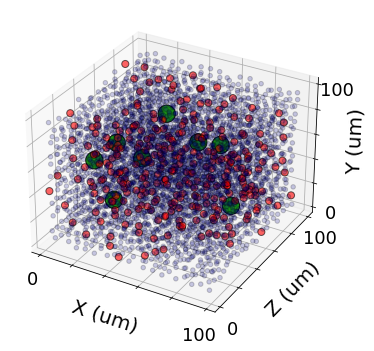

In [15]:

############################ First visualization of the cube ##################################

fig = plt.figure(figsize=(6,6))
plt.rcParams["savefig.facecolor"] = "white"
ax = fig.add_subplot(111, projection='3d')

plt.tick_params('both', labelsize=18) 

## simplifying ticks labels 
ticks = [0, 20, 40, 60, 80, 100]
ticks_labels = [0, "", "", "", "", 100]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_labels, fontsize=18)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_labels, fontsize=18)
ax.set_zticks(ticks)
ax.set_zticklabels(ticks_labels, fontsize=18)

## separating coordinates
xglo, yglo, zglo = separate_coords(glos)
xgrc, ygrc, zgrc = separate_coords(grcs)
xgoc, ygoc, zgoc = separate_coords(gocs)

## plotting cells positions for each population
ax.scatter(xgrc,ygrc,zgrc, c ='darkblue', alpha=0.2, edgecolor='black', label = 'GRC')
ax.scatter(xglo,yglo,zglo, s = 50, c='red', alpha=0.6, edgecolor='black', label = 'MF')
ax.scatter(xgoc,ygoc,zgoc, s = 300, c ='green', alpha=0.9, edgecolor='black', label = 'GoC')

## labels
ax.set_xlabel("X (um)", fontsize=20)
ax.set_ylabel("Z (um)", fontsize=20)
ax.set_zlabel("Y (um)", fontsize=20)

# ax.legend(loc="best", ncol = 3, fontsize=20)

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'cube_100um.png'), dpi = 200, bbox_inches = 'tight'
)

# CONNECTIONS GENERATION

In [16]:
print('Number of each cell population inside the cube:')
print('MF: ', glos.shape[0])
print('GRC: ', grcs.shape[0])
print('GOCS: ', gocs.shape[0])

Number of each cell population inside the cube:
MF:  300
GRC:  3760
GOCS:  8


**NB**: For the anatomical model, in order to avoid possible boundary effects, when connecting neurons, ends of all cube axes were considered as a continuity of their beginnings, simulating an infinite cube. 

##  MF -> GRC EXCITATION

In [17]:
# Saving the number of cells for each population
n_glo = glos.shape[0]
n_grc = grcs.shape[0]
n_goc = gocs.shape[0]

In [18]:
# Selecting the closest MFs to each GrC soma

glos_to_grc = []
distances_2 = []

for i in range(grcs.shape[0]):
    
    indexes = []
    distances = []
    
    for j in range(glos.shape[0]):
        
        ## Calculating distances
        dist2 = np.zeros((3))
        dist2 = grcs[i] - glos[j]
        ## Applying the "infinite" cube 
        for x in range(3):
            if abs(dist2[x]) > 50:
                dist2[x] = 100 - grcs[i][x] + glos[j][x]
        temp = dist2
        dist = np.sqrt(np.dot(temp, temp))  # euclidean distance of grc_i and glo_j
        
        ## Selecting closest ones 
        if dist < 40.0:
            indexes.append(j)
            distances.append(dist)
            
    lista = list(zip(distances, indexes))     # sort by distance and choose the first 4 MF
    
    ## Keeping the closest 4 MFs
    lista = sorted(lista,key=itemgetter(0))[0:4] # save the indexes
    
    glos_to_grc.append([x[1] for x in lista])
    distances_2.append([x[0] for x in lista])
    

In [19]:
## transforming our list from glos_to_grc to grcs_to_glo (inverting lists)

grcs_to_glo = [[] for _ in range(glos.shape[0])]

for elem in range(glos.shape[0]):

    for j in range(len(glos_to_grc)):

        if elem in glos_to_grc[j]:
            
            grcs_to_glo[elem].append(j)

In [20]:
## checking mfs divergence

distances_2 = list(chain.from_iterable(distances_2))

c = Counter(x for sublist in glos_to_grc for x in sublist)
c = c.items()
mfs_div = np.array([x[1] for x in c])
#distances_2 = np.array([x[0] for x in distances_2])

print('Each MF/GLO receives on average ' + str(mfs_div.mean()) + ' GRCs dendrites')
print('Mean distance of MF - GRC connection is ' + str(np.array(distances_2).mean()))

Each MF/GLO receives on average 50.13333333333333 GRCs dendrites
Mean distance of MF - GRC connection is 12.007647284703303


## MF - GRC convergence plot 

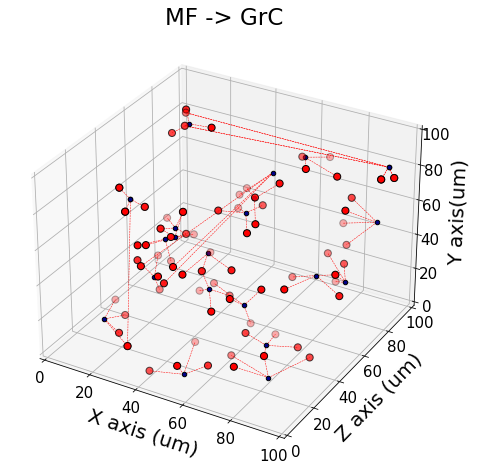

In [21]:

plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

## we select a small group of grcs for the final figure
## alternatively, for all the grcs, just replace "grcs_selected" by "grcs" 
grcs_selected = [0, 333, 666, 1000, 1333, 1666, 2000, 2333, 2666, 40, 80, 120, 160, 1200, 1400, 3400, 3200, 3100,
                2400, 3100, 3300, 3345]

for grc in grcs_selected: 
    glos_plot = glos[glos_to_grc[grc]]
    xglo, yglo, zglo = separate_coords(glos_plot)
    xgrc, ygrc, zgrc = grcs[grc][0], grcs[grc][1], grcs[grc][2]

    ax.scatter(xglo,zglo,yglo, s = 50,  c = 'red', edgecolors='black')
    ax.scatter(xgrc,zgrc,ygrc, c = 'darkblue', edgecolors='black')

    for i in range(len(xglo)):
        x = [xgrc, xglo[i]]
        y = [ygrc, yglo[i]]
        z = [zgrc, zglo[i]]
        ax.plot(x, z, y, color='red', ls = '--', lw = 0.5)
        

ax.scatter(xglo,zglo,yglo, s = 50, label='MF', c = 'red', edgecolors='black')
ax.scatter(xgrc,zgrc,ygrc, c = 'darkblue', label='GRC', edgecolors='black')

ax.set_xlim(0.0, total_size)
ax.set_ylim(0.0, total_size)
ax.set_zlim(0.0, total_size)

ax.set_xlabel("X axis (um)", fontsize=20)
ax.set_ylabel("Z axis (um)", fontsize=20)
ax.set_zlabel("Y axis(um)", fontsize=20)
ax.set_title("MF -> GrC", fontsize=23)

ax.tick_params(labelsize=15)

#ax.legend(loc="best", fontsize=20)

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'mf_grc_conv.png'), dpi = 200, bbox_inches = 'tight'
)


In [22]:

## Selecting only one GrC to visualize

n = 2670
glos_plot = glos[glos_to_grc[n]]

xglo, yglo, zglo = separate_coords(glos_plot)
xgrc, ygrc, zgrc = grcs[n][0], grcs[n][1], grcs[n][2]

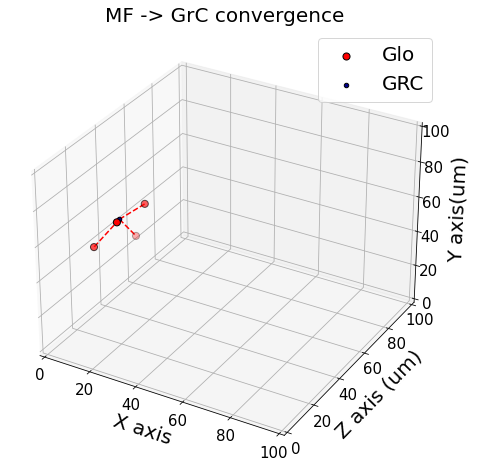

In [23]:

plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xglo,zglo,yglo, s = 50, label='Glo', c = 'red', edgecolors='black')
ax.scatter(xgrc,zgrc,ygrc, c = 'darkblue', label='GRC', edgecolors='black')

for i in range(len(xglo)):
    x = [xgrc, xglo[i]]
    y = [ygrc, yglo[i]]
    z = [zgrc, zglo[i]]
    ax.plot(x, z, y, color='red', ls = '--')
    
ax.set_xlim(0.0, total_size)
ax.set_ylim(0.0, total_size)
ax.set_zlim(0.0, total_size)
    
ax.set_xlabel("X axis", fontsize=20)
ax.set_ylabel("Z axis (um)", fontsize=20)
ax.set_zlabel("Y axis(um)", fontsize=20)
ax.set_title("MF -> GrC convergence", fontsize=20)
ax.tick_params(labelsize=15)

ax.legend(loc="best", fontsize=20)

plt.show()

## MF -> GoC excitation

GoCs received excitation from 50 glomeruli and 100 GrCs through parallel fibers randomly selected within the network.

In [24]:

glomeruli = glos
golgis = gocs
first_glomerulus = glos[0]
r_goc_vol = 50 #50 um dendrite radius
glos_goc_exc = []


glom_bd = np.zeros((0,2))
glom_x = glomeruli[:,0]
glom_y = glomeruli[:,1]
glom_z = glomeruli[:,2]

## for all Golgi cells: calculate which glomeruli fall into the volume of GoC basolateral dendrites, then choose 40 of them for the connection and delete them from successive computations, since 1 axon is connected to 1 GoC
for i in range(gocs.shape[0]):

    golgi_x = golgis[i][0]
    golgi_y = golgis[i][1]
    golgi_z = golgis[i][2]

    golgi_id = i

    ## Geometric constraints: glom less than `r_goc_vol` away from golgi and golgi cell soma above glom.
    ## Applying the "infinite" cube
    dist_x = glom_x - golgi_x
    for j in range(dist_x.shape[0]):
        if abs(dist_x[j]) > 50:
            dist_x[j] = 100 - dist_x[j]

    dist_y = glom_y - golgi_y
    for j in range(dist_y.shape[0]):
        if abs(dist_y[j]) > 50:
            dist_y[j] = 100 - dist_y[j]

    dist_z = glom_z - golgi_z
    for j in range(dist_z.shape[0]):
        if abs(dist_z[j]) > 50:
            dist_z[j] = 100 - dist_z[j]

    ## Calculating the volume
    volume_matrix = (((dist_x**2)+((dist_y**2))+((dist_z**2)))-(r_goc_vol**2)).__le__(0) & (dist_y).__le__(0)

    good_gloms = np.where(volume_matrix==True)[0] # finds indexes of granules that can potentially be connected
    connected_gloms = good_gloms  # Translate local id to simulation id

    matrix = np.zeros((len(good_gloms), 2))
    matrix[:,0] = connected_gloms # from cell
    matrix[:,1] = golgi_id# to cell
    glom_bd = np.vstack((glom_bd, matrix))
    glos_goc_exc.append(matrix[:,0])


## MF -> GOC convergence plot

In [25]:
# Selecting only one GoC for the visualization
n = 6
glos_plot = glos[glos_goc_exc[n].astype(int)]

xglo, yglo, zglo = separate_coords(glos_plot)
xgoc, ygoc, zgoc = gocs[n][0], gocs[n][1], gocs[n][2]

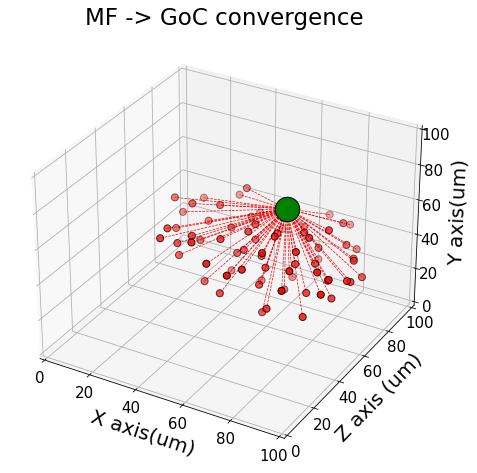

In [26]:

plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xglo,zglo,yglo, s = 50, label='MF', c = 'red', edgecolors='black')
ax.scatter(xgoc,zgoc,ygoc, s = 600, c = 'green', label='GoC', edgecolors='black')

for i in range(len(xglo)):
    x = [xgoc, xglo[i]]
    y = [ygoc, yglo[i]]
    z = [zgoc, zglo[i]]
    ax.plot(x, z, y, color='red', ls = '--', lw = 0.7)
    
ax.set_xlim(0.0, total_size)
ax.set_ylim(0.0, total_size)
ax.set_zlim(0.0, total_size)
    
ax.set_xlabel("X axis(um)", fontsize=20)
ax.set_ylabel("Z axis (um)", fontsize=20)
ax.set_zlabel("Y axis(um)", fontsize=20)
ax.set_title("MF -> GoC convergence", fontsize=23)

ax.tick_params(labelsize=15)

#ax.legend(loc="best", fontsize=20)

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'mf_goc_conv.png'), dpi = 200, bbox_inches = 'tight'
)


## MF -> GoC excitation 

In [27]:
## MFs convergence to GoCs

mf_goc_div_count = Counter(x for sublist in glos_goc_exc for x in sublist)
mf_goc_div_count = mf_goc_div_count.items()
mf_goc_div = np.array([x[1] for x in mf_goc_div_count])

print('Each MF reaches on average ' + str(mf_goc_div.mean()) + ' GoCs')

Each MF reaches on average 2.261467889908257 GoCs


Text(0.5, 1.0, 'MF -> GoC divergence')

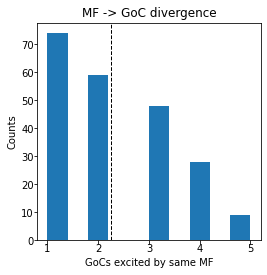

In [28]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111)
ax.hist(mf_goc_div)

ax.set_xlabel("GoCs excited by same MF", fontsize=10)
ax.set_ylabel("Counts", fontsize=10)
ax.axvline(mf_goc_div.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title("MF -> GoC divergence")

## GrC -> GoC excitation

In [29]:
## Function to connect GrCs to GoCs via ascendent axons and parallel fibers

granules = grcs
golgis = gocs
first_granule = int(0)
r_goc_vol = 50
oob = total_size * 1000. # Any arbitrarily large value outside of simulation volume
n_connAA = 400
n_conn_pf = 1200
tot_conn = n_connAA + n_conn_pf
aa_goc_exc = []
pf_goc_exc = []

def connectome_grc_goc(first_granule, granules, golgicells, r_goc_vol, OoB_value, n_connAA, n_conn_pf, tot_conn):
    aa_goc = np.empty((0,2))
    pf_goc = np.empty((0,2))
    
    densityWarningSent = False
    new_granules = np.copy(granules)
    granules_x = new_granules[:,0]
    granules_z = new_granules[:,2]
    new_golgicells = gocs
    lista_gocs = list(range(len(new_golgicells)))
    random.shuffle(lista_gocs)
    
    if new_granules.shape[0] <= new_golgicells.shape[0]:
        
        raise Exception("The number of granule cells was less than the number of golgi cells. Simulation cannot continue.")
    
    for i in lista_gocs:
        
        golgi_x = new_golgicells[i][0]
        golgi_y = new_golgicells[i][1]
        golgi_z = new_golgicells[i][2]
        golgi_id = i
    
        ## Applying the "infinite" cube
        dist_x = granules_x - golgi_x
        for j in range(dist_x.shape[0]):
            if abs(dist_x[j]) > 50:
                dist_x[j] = 100 - dist_x[j]

        dist_z = granules_z - golgi_z
        for j in range(dist_z.shape[0]):
            if abs(dist_z[j]) > 50:
                dist_z[j] = 100 - dist_z[j]


        # Distance of this golgi cell to all ascending axons
        distance_vector = ((dist_x)**2)+((dist_z)**2)
        AA_candidates = np.where((distance_vector).__le__(r_goc_vol**2))[0] # finds indexes of ascending axons that can potentially be connected

        chosen_rand = np.random.permutation(AA_candidates)
        selected_granules = new_granules[chosen_rand]
        selected_distances = np.sqrt(distance_vector[chosen_rand])
        prob = selected_distances / r_goc_vol
        distance_sort = prob.argsort()
        selected_granules = selected_granules[distance_sort]
        prob = prob[distance_sort]
        rolls = np.random.uniform(size=len(selected_granules))
        connectedAA = np.empty(n_connAA)
        idx = 0
        
        for ind in range(len(selected_granules)):
            if idx < n_connAA:
                if rolls[ind] > prob[ind]:
                    connectedAA[idx] = chosen_rand[ind]
                    idx += 1
        connectedAA = connectedAA[0:idx]

        connectedAA = [connectedAA[i].astype(int) for i in range(len(connectedAA))]
        connectedAA = np.array(connectedAA)        
        good_grc = new_granules
        good_grc[connectedAA,:] = OoB_value
        good_grc[first_granule,:] = OoB_value
        intersections = (good_grc[:,0]).__ge__(golgi_x-r_goc_vol) & (good_grc[:,0]).__le__(golgi_x+r_goc_vol)
        good_pf = np.where(intersections==True)[0]  
     
                               
        # The remaining amount of parallel fibres to connect after subtracting the amount of already connected ascending axons.
        AA_connected_count = len(connectedAA)
        
        ### Parallel fibers connections
        parallelFibersToConnect = tot_conn - AA_connected_count
        
        # Randomly select parallel fibers to be connected with a GoC, to a maximum of tot_conn connections
        if good_pf.shape[0] < parallelFibersToConnect:
            connected_pf = np.random.choice(good_pf, min(tot_conn-AA_connected_count, good_pf.shape[0]), replace = False)
            
            totalConnectionsMade = connected_pf.shape[0] + AA_connected_count
            # Warn the user once if not enough granule cells are present to connect to the Golgi cell.
            if not densityWarningSent:
                densityWarningSent = True
                print("[WARNING] The granule cell density is too low compared to the Golgi cell density to make physiological connections!")
        else:

            connected_pf = np.random.choice(good_pf, tot_conn-len(connectedAA), replace = False)
            totalConnectionsMade = tot_conn
        

        PF_connected_count = connected_pf.shape[0]
        pf_idx = good_grc[connected_pf,:]
        aa_idx = good_grc[connectedAA,:]

        matrix_aa = np.zeros((AA_connected_count, 3))
        matrix_pf = np.zeros((PF_connected_count, 3))
        matrix_aa = aa_idx
        matrix_pf = pf_idx

        aa_goc_exc.append(connectedAA)
        pf_goc_exc.append(connected_pf)

        new_granules[((connectedAA.astype(int)) - first_granule),:] = OoB_value


    return aa_goc_exc, pf_goc_exc

result_aa, result_pf = connectome_grc_goc(first_granule, granules, golgis, r_goc_vol, oob, n_connAA, n_conn_pf, tot_conn)

[WARNING] The granule cell density is too low compared to the Golgi cell density to make physiological connections!


## GrC -> GoC excitation

In [30]:
# Selecting one GoC for the visualization
n = 1
aa_goc_exc = [aa_goc_exc[i].astype(int) for i in range(len(aa_goc_exc))]
pf_goc_exc = [pf_goc_exc[i].astype(int) for i in range(len(pf_goc_exc))]

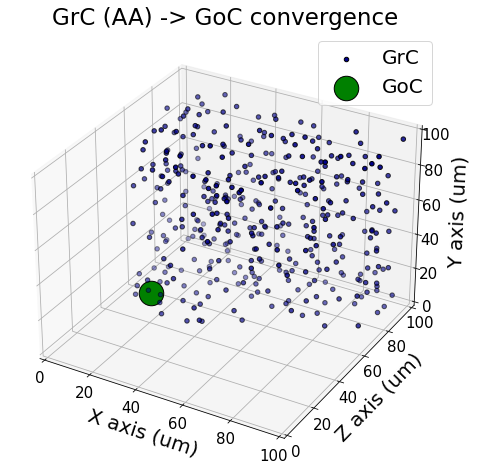

In [31]:
## Ascendent axons connections

grcs_plot = grcs[aa_goc_exc[n]]
xgrc, ygrc, zgrc = separate_coords(grcs_plot)
xgoc, ygoc, zgoc = gocs[n][0], gocs[n][1], gocs[n][2]

plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xgrc,zgrc,ygrc, c ='darkblue', label='GrC', edgecolors='black')
ax.scatter(xgoc,zgoc,ygoc, s = 600, c = 'green', label='GoC', edgecolors='black')

ax.set_xlim(0.0, total_size)
ax.set_ylim(0.0, total_size)
ax.set_zlim(0.0, total_size)
    
ax.set_xlabel("X axis (um)", fontsize=20)
ax.set_ylabel("Z axis (um)", fontsize=20)
ax.set_zlabel("Y axis (um)", fontsize=20)
ax.set_title("GrC (AA) -> GoC convergence", fontsize=23)

ax.tick_params(labelsize=15)

ax.legend(loc="best", fontsize=20)

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'grc_aa_goc_conv.png'), dpi = 200, bbox_inches = 'tight'
)


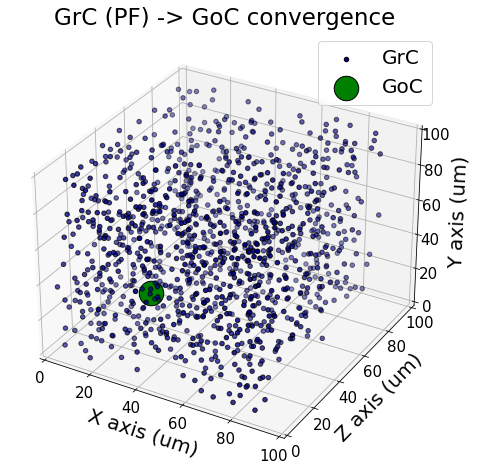

In [32]:
## Parallel fibers connections

grcs_plot = grcs[pf_goc_exc[n]]
xgrc, ygrc, zgrc = separate_coords(grcs_plot)
xgoc, ygoc, zgoc = gocs[n][0], gocs[n][1], gocs[n][2]

plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xgrc,zgrc,ygrc, c ='darkblue', label='GrC', edgecolors='black')
ax.scatter(xgoc,zgoc,ygoc, s = 600, c = 'green', label='GoC', edgecolors='black')

ax.set_xlim(0.0, total_size)
ax.set_ylim(0.0, total_size)
ax.set_zlim(0.0, total_size)
    
ax.set_xlabel("X axis (um)", fontsize=20)
ax.set_ylabel("Z axis (um)", fontsize=20)
ax.set_zlabel("Y axis (um)", fontsize=20)
ax.set_title("GrC (PF) -> GoC convergence", fontsize=23)

ax.tick_params(labelsize=15)

ax.legend(loc="best", fontsize=20)

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'grc_pf_goc_conv.png'), dpi = 200, bbox_inches = 'tight'
)


## GOC -> GRC inhibition


(c) Only one GoC axon was allowed to enter a glomerulus forming inhibitory synapes on all afferent GrC dendrites

(d) A GoC axon entering into 1 glomerulus was prevented from accesing the neighboring glomeruli sharing GrCs with the first glomerulus. This prevented a GrC from being inhibited twice by through the same GoC

(d) Each GoC was allowed to access at most 40 glomeruli resulting in a maximum ~2000 GrCs inhibited by the same GoC. 

In [33]:
## Function to connect GoCs to GrCs 

glomeruli = glos
golgis = gocs
first_glomerulus = int(0)
GoCaxon_x = 150
GoCaxon_y = 150
GoCaxon_z = 30
r_glom = 1.5
n_conn_goc = 40
layer_thickness = size
# An arbitrarily large value that will be used to exclude cells from geometric constraints
oob = total_size * 1000.
gocs_to_glo = []

def connectome_goc_glom(first_glomerulus, glomeruli, golgicells, GoCaxon_x, GoCaxon_y, GoCaxon_z, r_glom, n_conn_goc, layer_thickness, oob):
    
    temp = np.zeros((len(glomeruli),4))
    for i in range(len(glomeruli)):
        temp[i] = np.insert(glomeruli[i],0,i)

    #new_glomeruli = np.copy(glomeruli)
    new_glomeruli = temp
    
    glom_x = glomeruli[:,0]
    glom_y = glomeruli[:,1]
    glom_z = glomeruli[:,2]
    
           
    temp = np.zeros((len(golgicells),4))
    for i in range(len(golgicells)):
        temp[i] = np.insert(golgicells[i],0,i)

    new_golgicells = np.random.permutation(temp)
    
    connections = np.zeros((golgis.shape[0] * n_conn_goc ,2))
    new_connection_index = 0

    # for all Golgi cells: calculate which glomeruli fall into the area of GoC axon, then choose 40 of them for the connection and delete them from successive computations, since 1 glomerulus must be connected to only 1 GoC
    for i in range(len(new_golgicells)):
        
        golgi_x = new_golgicells[i][1]
        golgi_y = new_golgicells[i][2]
        golgi_z = new_golgicells[i][3]
        golgi_id = new_golgicells[i][0]
    
        ## Check geometrical constraints
        
        ## Applying the "infinite" cube
        dist_x = glom_x - golgi_x
        for j in range(dist_x.shape[0]):
            if abs(dist_x[j]) > 50:
                dist_x[j] = 100 - dist_x[j]
                
        dist_y = glom_y - golgi_y
        for j in range(dist_y.shape[0]):
            if abs(dist_y[j]) > 50:
                dist_y[j] = 100 - dist_y[j]        

        dist_z = glom_z - golgi_z
        for j in range(dist_z.shape[0]):
            if abs(dist_z[j]) > 50:
                dist_z[j] = 100 - dist_z[j]
        
        # glomerulus falls into the x range of values?
        bool_vector = ((dist_x + r_glom + GoCaxon_x/2.).__ge__(0.0)) & ((dist_x - r_glom-GoCaxon_x/2.).__le__(0.0))
        # glomerulus falls into the y range of values?
        bool_vector = bool_vector & ((dist_y + r_glom + GoCaxon_y/2.).__ge__(0.0)) & ((dist_y - r_glom-GoCaxon_y/2.).__le__(0.0))
        # glomerulus falls into the z range of values?
        bool_vector = bool_vector & ((dist_z + r_glom + GoCaxon_z/2.).__ge__(0.0)) & ((dist_z - r_glom-GoCaxon_z/2.).__le__(0.0))

        # Make a permutation of all candidate glomeruli
        good_gloms = np.where(bool_vector)[0]
        chosen_rand = np.random.permutation(good_gloms)
        good_gloms_matrix = new_glomeruli[chosen_rand]
        # Calculate the distance between the golgi cell and all glomerulus candidates, normalize distance by layer thickness
        
        dist_x = good_gloms_matrix[:,1] - golgi_x
        for j in range(dist_x.shape[0]):
            if abs(dist_x[j]) > 50:
                dist_x[j] = 100 - dist_x[j]
                
        dist_y = good_gloms_matrix[:,2] - golgi_y
        for j in range(dist_y.shape[0]):
            if abs(dist_y[j]) > 50:
                dist_y[j] = 100 - dist_y[j]        


        good_gloms_matrix[:,1]
        normalized_distance_vector = np.sqrt((dist_x)**2 + (dist_y)**2) / layer_thickness
        sorting_map = normalized_distance_vector.argsort()
        # Sort the candidate glomerulus matrix and distance vector by the distance vector
        good_gloms_matrix = good_gloms_matrix[sorting_map]
        # Use the normalized distance vector as a probability treshold for connecting glomeruli
        probability_treshold = normalized_distance_vector[sorting_map]

        idx = 1
        for candidate_index, glomerulus in enumerate(good_gloms_matrix):
            if idx <= n_conn_goc:
                ra = np.random.random()
                if (ra).__gt__(probability_treshold[candidate_index]):
                    glomerulus_id = glomerulus[0]
                    connections[new_connection_index, 0] = golgi_id
                    connections[new_connection_index, 1] = glomerulus_id + first_glomerulus
                    new_glomeruli[int(glomerulus_id - first_glomerulus),:] = oob
                    new_connection_index += 1
                    idx += 1
                    
        
        
    return connections[0:new_connection_index]

result = connectome_goc_glom(first_glomerulus, glomeruli, golgis, GoCaxon_x, GoCaxon_y, GoCaxon_z, r_glom, n_conn_goc, layer_thickness, oob)

In [34]:
# Assigning each MF to a goc axon
gocs_to_glo = []
for j in range(glos.shape[0]):
    gocs_to_glo_2 = []
    for i in range(result.shape[0]):
        if result[i][1] == j:
            gocs_to_glo_2.append(result[i][0])
            
    gocs_to_glo.append(gocs_to_glo_2)


In [35]:
## Checking how many glomeruli reaches each goc

from collections import Counter
flat_list = [item for sublist in gocs_to_glo for item in sublist]
g = Counter(x for x in flat_list)
g = g.items()
g_freq = np.array([x[1] for x in g])

print('The average number of glomeruli that each goc reaches is ' + str(g_freq.mean()))

The average number of glomeruli that each goc reaches is 27.75


In [36]:
## Defining the inhibitory connections GoC -> GRC

goc_to_grcs = [[] for _ in range(n_goc)]

i = 0

for elem in gocs_to_glo:
    print(elem)
    if elem != []: 
        elem = int(elem[0])           
        goc_to_grcs[elem].append(grcs_to_glo[i])
    i += 1
    
goc_to_grcs_2 = []

for i in range(len(goc_to_grcs)):
    newlist = [item for items in goc_to_grcs[i] for item in items]
    goc_to_grcs_2.append(newlist)
    
goc_to_grcs = goc_to_grcs_2

[5.0]
[]
[]
[2.0]
[2.0]
[2.0]
[2.0]
[2.0]
[]
[1.0]
[1.0]
[]
[1.0]
[7.0]
[]
[]
[]
[]
[]
[]
[1.0]
[2.0]
[2.0]
[1.0]
[1.0]
[1.0]
[]
[1.0]
[]
[]
[]
[]
[]
[2.0]
[2.0]
[]
[]
[2.0]
[3.0]
[]
[3.0]
[3.0]
[]
[5.0]
[3.0]
[]
[3.0]
[]
[]
[3.0]
[]
[2.0]
[2.0]
[2.0]
[]
[1.0]
[]
[1.0]
[7.0]
[1.0]
[]
[2.0]
[6.0]
[]
[6.0]
[6.0]
[]
[3.0]
[]
[]
[3.0]
[]
[2.0]
[2.0]
[2.0]
[3.0]
[3.0]
[3.0]
[3.0]
[3.0]
[2.0]
[2.0]
[2.0]
[1.0]
[1.0]
[1.0]
[7.0]
[7.0]
[7.0]
[1.0]
[]
[4.0]
[5.0]
[2.0]
[2.0]
[6.0]
[3.0]
[]
[]
[3.0]
[3.0]
[]
[3.0]
[]
[3.0]
[3.0]
[3.0]
[5.0]
[]
[2.0]
[2.0]
[2.0]
[2.0]
[2.0]
[1.0]
[1.0]
[1.0]
[]
[7.0]
[1.0]
[1.0]
[7.0]
[]
[]
[1.0]
[1.0]
[4.0]
[7.0]
[4.0]
[1.0]
[]
[7.0]
[1.0]
[1.0]
[1.0]
[1.0]
[2.0]
[5.0]
[2.0]
[2.0]
[5.0]
[5.0]
[3.0]
[3.0]
[]
[5.0]
[2.0]
[2.0]
[2.0]
[4.0]
[1.0]
[]
[]
[1.0]
[1.0]
[1.0]
[]
[]
[4.0]
[5.0]
[6.0]
[5.0]
[4.0]
[6.0]
[0.0]
[6.0]
[]
[5.0]
[2.0]
[2.0]
[1.0]
[7.0]
[1.0]
[7.0]
[1.0]
[7.0]
[4.0]
[4.0]
[7.0]
[7.0]
[0.0]
[4.0]
[7.0]
[7.0]
[7.0]
[7.0]
[7.0]
[]
[7.0]
[7.0]
[7.0]
[

In [37]:
gocs_div = []
for i in range(len(goc_to_grcs)):
    gocs_div.append(len(goc_to_grcs[i]))
    
print('Average ratio of divergence for GoC population ' + str(np.array(gocs_div).mean()))

Average ratio of divergence for GoC population 1377.625


In [38]:
## Checking how many glomeruli reaches each goc

flat_list = [item for sublist in gocs_to_glo for item in sublist]

g = Counter(x for x in flat_list)
g = g.items()
g_freq = np.array([x[1] for x in g])

print('The average number of glomeruli that each goc reaches is ' + str(g_freq.mean()))

The average number of glomeruli that each goc reaches is 27.75


In [39]:
glos_to_goc = []

for i in range(gocs.shape[0]):
    glos_to_goc_2 = []
    for j in range(result.shape[0]):
        if result[j][0] == i:
            glos_to_goc_2.append(result[j][1])
            
    glos_to_goc.append(glos_to_goc_2)
            

In [40]:
glos_to_goc = [[int(x) for x in lista] for lista in glos_to_goc]

In [41]:
# Selecting one GoC for the visualization
n = 6
grcs_plot = grcs[goc_to_grcs[n]]
glos_plot = glos[glos_to_goc[n]]
gocs_plot = gocs[n]

In [42]:
xglo, yglo, zglo = separate_coords(glos_plot)
xgrc, ygrc, zgrc = separate_coords(grcs_plot)
xgoc, ygoc, zgoc = gocs[n][0], gocs[n][1], gocs[n][2]

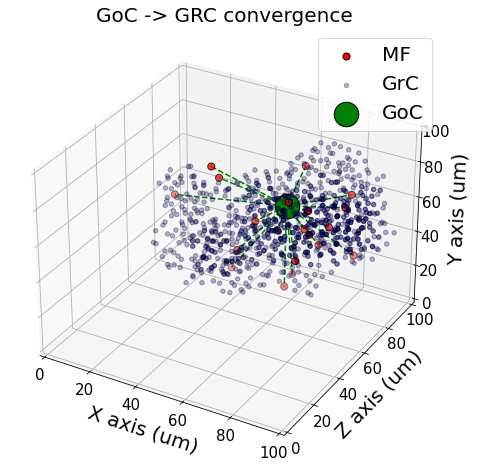

In [43]:

plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(xglo,zglo,yglo, s = 50, label='MF', c = 'red', edgecolors='black')
ax.scatter(xgrc,ygrc,zgrc, c ='darkblue', label='GrC', edgecolors='black', alpha = 0.3)
ax.scatter(xgoc,zgoc,ygoc, s = 600, c = 'green', label='GoC', edgecolors='black')


for i in range(len(xglo)):
    x = [xgoc, xglo[i]]
    y = [ygoc, yglo[i]]
    z = [zgoc, zglo[i]]
    ax.plot(x, z, y, color='green', ls = '--')
        
ax.set_xlim(0.0, total_size)
ax.set_ylim(0.0, total_size)
ax.set_zlim(0.0, total_size)

ax.set_xlabel("X axis (um)", fontsize=20)
ax.set_ylabel("Z axis (um)", fontsize=20)
ax.set_zlabel("Y axis (um)", fontsize=20)
ax.set_title("GoC -> GRC convergence", fontsize=20)
ax.tick_params(labelsize=15)

ax.legend(loc="best", fontsize=20)

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'goc_grc_conv.png'), dpi = 200, bbox_inches = 'tight'
)



# Testing the neural network

### MF -> GRC excitation

In [44]:
## checking glo/mfs divergence to grcs

mf_grc_div_count = Counter(x for sublist in glos_to_grc for x in sublist)
mf_grc_div_count = mf_grc_div_count.items()
mf_grc_div = np.array([x[1] for x in mf_grc_div_count])

print('Each MF/GLO reaches on average ' + str(mf_grc_div.mean()) + ' GRCs dendrites')
#print('Mean distance of MF - GRC connection is ' + str(np.array(distances_2).mean()))

Each MF/GLO reaches on average 50.13333333333333 GRCs dendrites


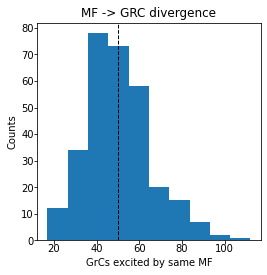

In [45]:
fig = plt.figure(figsize=(4,4))


ax = fig.add_subplot(111)
ax.hist(mf_grc_div)

ax.set_xlabel("GrCs excited by same MF", fontsize=10)
ax.set_ylabel("Counts", fontsize=10)
ax.axvline(mf_grc_div.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title("MF -> GRC divergence")

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'mf_grc_stats.png'), dpi = 200, bbox_inches = 'tight'
)


In [46]:
## glo/mfs convergence is 1:4, constraint from the beginning 

mf_grc_conv_count = Counter(x for sublist in grcs_to_glo for x in sublist)
mf_grc_conv_count = mf_grc_conv_count.items()
mf_grc_conv = np.array([x[1] for x in mf_grc_conv_count])

print('Each GRC receives on average ' + str(mf_grc_conv.mean()) + ' MFs')
#print('Mean distance of MF - GRC connection is ' + str(np.array(distances_2).mean()))

Each GRC receives on average 4.0 MFs


### MF -> GoC excitation 

In [47]:
## glo/mfs convergence to GoC is a contraint from the beginning 50:1
## glo/mfs divergence to GoC

mf_goc_div_count = Counter(x for sublist in glos_goc_exc for x in sublist)
mf_goc_div_count = mf_goc_div_count.items()
mf_goc_div = np.array([x[1] for x in mf_goc_div_count])

print('Each MF reaches on average ' + str(mf_goc_div.mean()) + ' GoCs')

Each MF reaches on average 2.261467889908257 GoCs


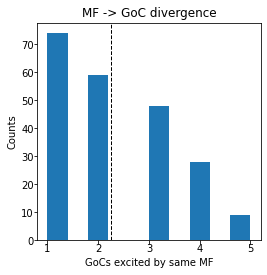

In [48]:
fig = plt.figure(figsize=(4,4))


ax = fig.add_subplot(111)
ax.hist(mf_goc_div)

ax.set_xlabel("GoCs excited by same MF", fontsize=10)
ax.set_ylabel("Counts", fontsize=10)
ax.axvline(mf_goc_div.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title("MF -> GoC divergence")

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'mf_goc_stats.png'), dpi = 200, bbox_inches = 'tight'
)


### GrC -> GoC excitation

In [49]:
grcs_goc_exc = [np.concatenate((a,b)) for a, b in zip(aa_goc_exc, pf_goc_exc)]

In [50]:
## GrG convergence to GoC is a contraint from the beginning 100:1

## GrG divergence to GoC

grc_goc_div_count = Counter(x for sublist in grcs_goc_exc for x in sublist)
grc_goc_div_count = grc_goc_div_count.items()
grc_goc_div = np.array([x[1] for x in grc_goc_div_count])

print('Each GRC reaches on average ' + str(grc_goc_div.mean()) + ' GoCs')

Each GRC reaches on average 2.9441340782122905 GoCs


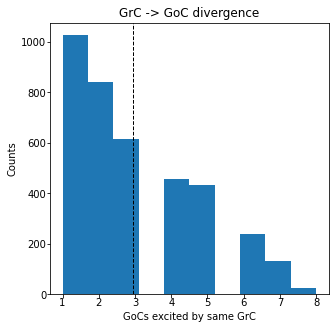

In [51]:
fig = plt.figure(figsize=(5,5))


ax = fig.add_subplot(111)
ax.hist(grc_goc_div)

ax.set_xlabel("GoCs excited by same GrC", fontsize=10)
ax.set_ylabel("Counts", fontsize=10)
ax.axvline(grc_goc_div.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title("GrC -> GoC divergence")

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'grc_goc_stats.png'), dpi = 200, bbox_inches = 'tight'
)



## GoC -> GrC inhibition 

In [52]:
## GoC convergence to GrC 

goc_grc_conv_count = Counter(x for sublist in goc_to_grcs for x in sublist)
goc_grc_conv_count = goc_grc_conv_count.items()
goc_grc_conv = np.array([x[1] for x in goc_grc_conv_count])

print('Each GoC reaches on average ' + str(goc_grc_conv.mean()) + ' GrCs')

Each GoC reaches on average 3.0269156825048062 GrCs


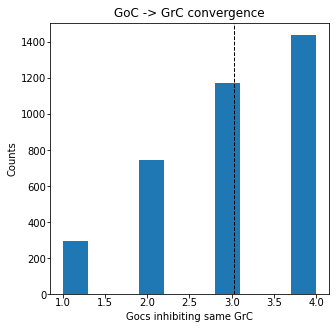

In [53]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.hist(goc_grc_conv)

ax.set_xlabel("Gocs inhibiting same GrC", fontsize=10)
ax.set_ylabel("Counts", fontsize=10)
ax.axvline(goc_grc_conv.mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title("GoC -> GrC convergence")

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'goc_grc_stats.png'), dpi = 200, bbox_inches = 'tight'
)


In [54]:
## Checking GoC -> GrC inhibition divergence

gocs_div = []
for i in range(len(goc_to_grcs)):
    gocs_div.append(len(goc_to_grcs[i]))
    
print('Average ratio of divergence for GoC population ' + str(np.array(gocs_div).mean()))

Average ratio of divergence for GoC population 1377.625


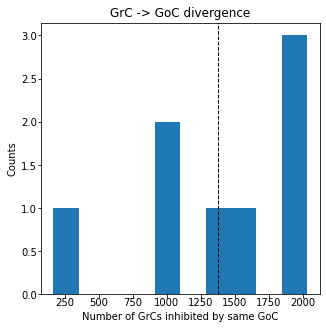

In [55]:
fig = plt.figure(figsize=(5,5))


ax = fig.add_subplot(111)
ax.hist(gocs_div)

ax.set_xlabel("Number of GrCs inhibited by same GoC", fontsize=10)
ax.set_ylabel("Counts", fontsize=10)
ax.axvline(np.array(gocs_div).mean(), color='k', linestyle='dashed', linewidth=1)

ax.set_title("GrC -> GoC divergence")

fig.savefig(
    os.path.join(VISUALIZATIONS_DIR, 'grc_goc_div_stats.png'), dpi = 200, bbox_inches = 'tight'
)



In [56]:
print('Each MF/GLO reaches on average ' + str(round(mf_grc_div.mean(),2)) + ' GRCs dendrites. Should be ~53.')
print('Each MF reaches on average ' + str(round(mf_goc_div.mean(),2)) + ' GoCs. Should be ~3.6.')
print('Each GRC reaches on average ' + str(round(grc_goc_div.mean(),2)) + ' GoCs. Should be ~1.9.')
print('Each GoC reaches on average ' + str(round(np.array(gocs_div).mean(),2)) + ' GrCs. Should be ~1200.')

Each MF/GLO reaches on average 50.13 GRCs dendrites. Should be ~53.
Each MF reaches on average 2.26 GoCs. Should be ~3.6.
Each GRC reaches on average 2.94 GoCs. Should be ~1.9.
Each GoC reaches on average 1377.62 GrCs. Should be ~1200.


In [57]:
## connection matrix glo to grc
conn_mat_glos_to_grc = np.zeros((n_glo, n_grc))

for i in range(len(grcs)):
    for elem in glos_to_grc[i]:
            conn_mat_glos_to_grc[elem][i] = 1
            
conn_mat_glos_to_grc.shape

(300, 3760)

In [58]:
## connection matrix glo to goc
conn_mat_glos_to_goc = np.zeros((n_glo, n_goc))

for i in range(len(gocs)):
    for elem in glos_goc_exc[i].astype(int):
            conn_mat_glos_to_goc[elem][i] = 1
            
conn_mat_glos_to_goc.shape

(300, 8)

In [59]:
## connection matrix grc to goc
conn_mat_grcs_to_goc = np.zeros((n_grc, n_goc))

for i in range(n_goc):
    for elem in grcs_goc_exc[i]:
            conn_mat_grcs_to_goc[elem][i] = 1
            
conn_mat_grcs_to_goc.shape

(3760, 8)

In [60]:
## connection matrix grc to goc
conn_mat_grcs_to_goc = np.zeros((n_grc, n_goc))

for i in range(n_goc):
    for elem in grcs_goc_exc[i]:
            conn_mat_grcs_to_goc[elem][i] = 1
            
conn_mat_grcs_to_goc.shape

(3760, 8)

In [61]:
## connection matrix goc to grc
conn_mat_goc_to_grcs = np.zeros((n_grc, n_goc))

for i in range(n_goc):
    for elem in goc_to_grcs[i]:
            conn_mat_goc_to_grcs[elem][i] = 1
            
conn_mat_goc_to_grcs.shape

(3760, 8)

## Saving the anatomical model data for the following steps

In [62]:
## Creating folders
DATA_DIR = '../data/structure'
SEED_DATA_DIR = os.path.join(DATA_DIR, 'seed' + str(seed))
os.makedirs(SEED_DATA_DIR, exist_ok=True) 
sys.path.insert(1, SEED_DATA_DIR)

In [63]:
with open(SEED_DATA_DIR + '/conn_mat_glos_to_grc.npy', 'wb') as f:
    np.save(f, conn_mat_glos_to_grc)
    
with open(SEED_DATA_DIR + '/conn_mat_glos_to_goc.npy', 'wb') as f:
    np.save(f, conn_mat_glos_to_goc)
    
with open(SEED_DATA_DIR + '/conn_mat_grcs_to_goc.npy', 'wb') as f:
    np.save(f, conn_mat_grcs_to_goc)
        
with open(SEED_DATA_DIR + '/conn_mat_goc_to_grcs.npy', 'wb') as f:
    np.save(f, conn_mat_goc_to_grcs)

In [64]:
with open(SEED_DATA_DIR + '/glos.npy', 'wb') as f:
    np.save(f, glos)
    
with open(SEED_DATA_DIR + '/grcs.npy', 'wb') as f:
    np.save(f, grcs)
    
with open(SEED_DATA_DIR + '/gocs.npy', 'wb') as f:
    np.save(f, gocs)     